Rows in Region III: 3237
Detected Columns -> Income: Total Household Income Food: Total Food Expenditure Employment: Household Head Marital Status


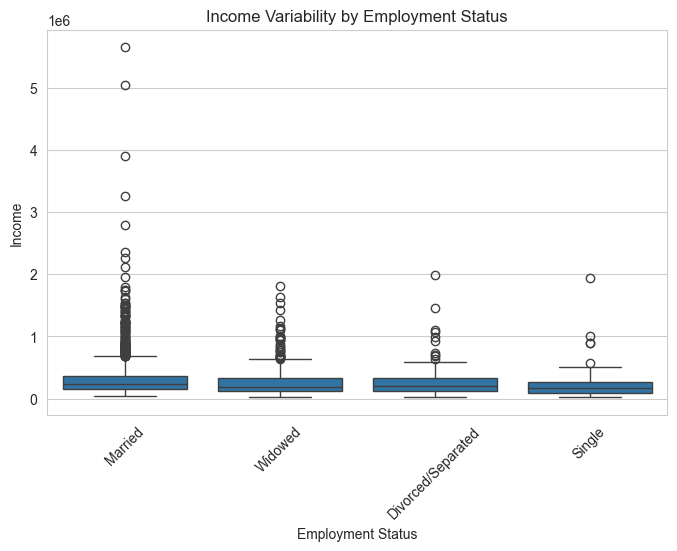

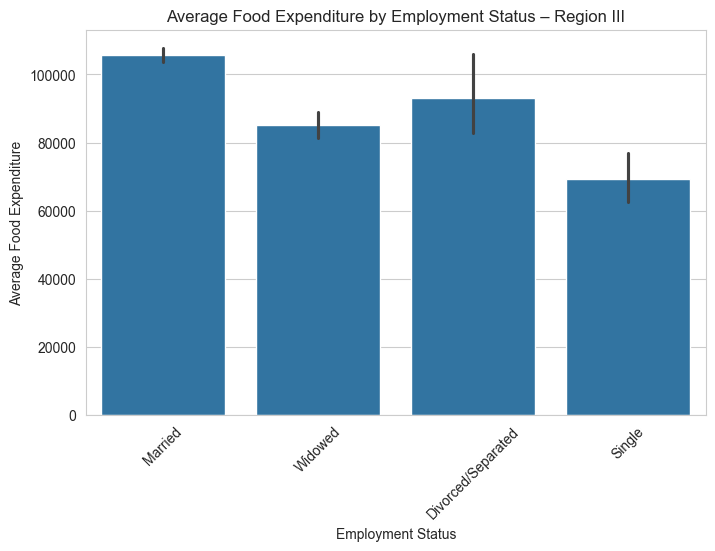

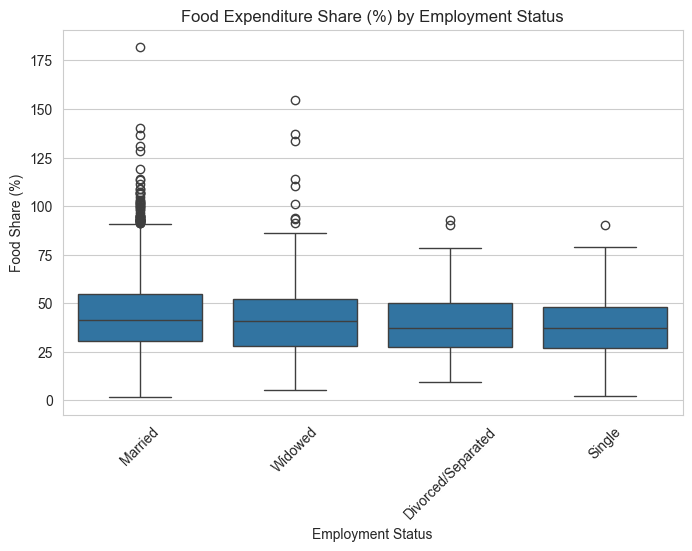

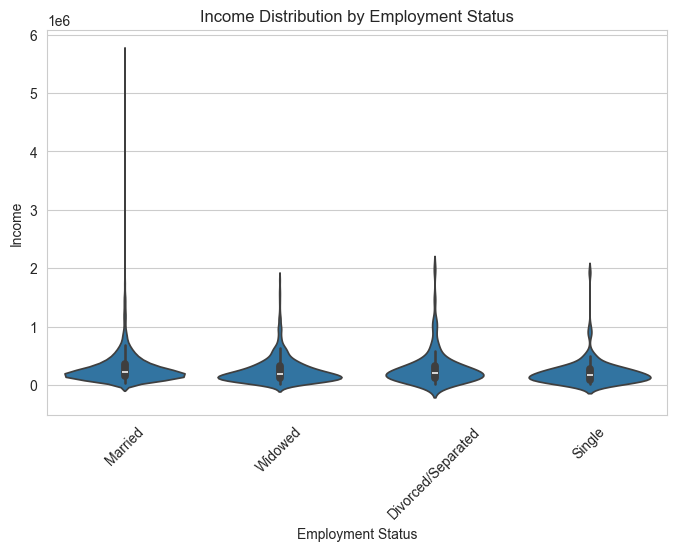

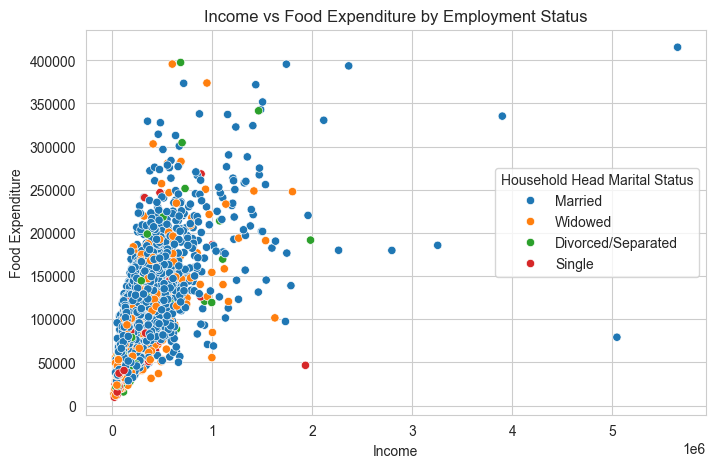

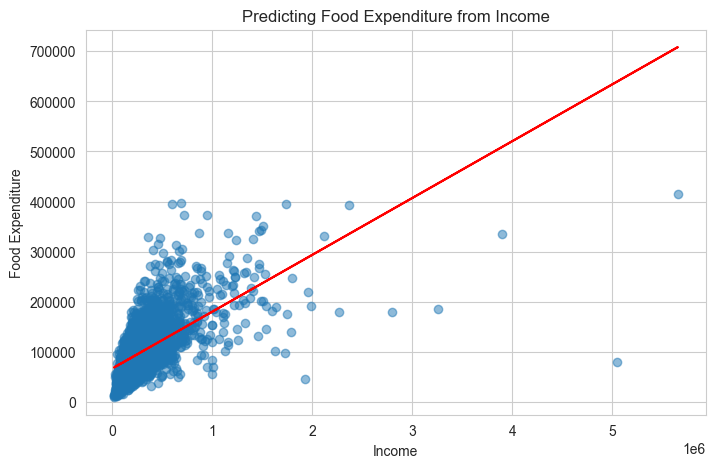

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
sns.set_style("whitegrid")

path = "/mnt/data/Family Income and Expenditure.csv"
df = pd.read_csv('Family Income and Expenditure.csv')

# 3. Filter Region III / Central Luzon

region_mask = pd.Series([False]*len(df))
for col in df.columns:
    if df[col].dtype == object:
        region_mask |= df[col].str.contains(r"\bIII\b|Region\s*III|Central\s*Luzon", flags=re.IGNORECASE, na=False)

region_df = df[region_mask].copy()
print("Rows in Region III:", len(region_df))

# 4. Identify columns

def find_col(patterns):
    for c in df.columns:
        for p in patterns:
            if re.search(p, c, re.IGNORECASE):
                return c
    return None

income_col = find_col(["income", "household income", "total household income"])
food_col = find_col(["food", "food expenditure"])
employment_col = find_col(["employment", "occupation", "workstatus", "status"])

print("Detected Columns -> Income:", income_col, "Food:", food_col, "Employment:", employment_col)

# 5. Clean numeric columns
for col in [income_col, food_col]:
    region_df[col] = (region_df[col].astype(str)
                      .str.replace(r"[^0-9.\-]", "", regex=True)
                      .replace("", np.nan)
                      .astype(float))

region_df[employment_col] = region_df[employment_col].astype(str).str.strip().replace({"nan": np.nan})


#Visualization 1: Part-time/informal income variability
plt.figure(figsize=(8,5))
sns.boxplot(x=employment_col, y=income_col, data=region_df)
plt.title("Income Variability by Employment Status")
plt.ylabel("Income")
plt.xlabel("Employment Status")
plt.xticks(rotation=45)
plt.show()

#Visualization 2: Unemployed households spend on essentials (food)
plt.figure(figsize=(8,5))
sns.barplot(x=employment_col, y=food_col, data=region_df, estimator=np.mean)
plt.title("Average Food Expenditure by Employment Status – Region III")
plt.ylabel("Average Food Expenditure")
plt.xlabel("Employment Status")
plt.xticks(rotation=45)
plt.show()

#Visualization 3: Food expenditure as largest share
region_df["Food_Share"] = region_df[food_col] / region_df[income_col] * 100
plt.figure(figsize=(8,5))
sns.boxplot(x=employment_col, y="Food_Share", data=region_df)
plt.title("Food Expenditure Share (%) by Employment Status")
plt.ylabel("Food Share (%)")
plt.xlabel("Employment Status")
plt.xticks(rotation=45)
plt.show()


#Visualization 4: Income inequality across employment
plt.figure(figsize=(8,5))
sns.violinplot(x=employment_col, y=income_col, data=region_df)
plt.title("Income Distribution by Employment Status")
plt.ylabel("Income")
plt.xlabel("Employment Status")
plt.xticks(rotation=45)
plt.show()

#Visualization 5: Spending proportional to income
plt.figure(figsize=(8,5))
sns.scatterplot(x=income_col, y=food_col, hue=employment_col, data=region_df)
plt.title("Income vs Food Expenditure by Employment Status")
plt.xlabel("Income")
plt.ylabel("Food Expenditure")
plt.show()

#Visualization 6: Predict food expenditure vs income
X = region_df[[income_col]].dropna()
y = region_df[food_col].loc[X.index]
model = LinearRegression()
model.fit(X, y)
plt.figure(figsize=(8,5))
plt.scatter(X, y, alpha=0.5)
plt.plot(X, model.predict(X), color='red')
plt.title("Predicting Food Expenditure from Income")
plt.xlabel("Income")
plt.ylabel("Food Expenditure")
plt.show()

